Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1220
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0591
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0317
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 13/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023
Epoch 14/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021
Epoch 15/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

<ipython-input-63-da03c18467dd>:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['date'] = pd.to_datetime(anomalies['year'] * 1000 + anomalies['day_of_year'], format='%Y%j')


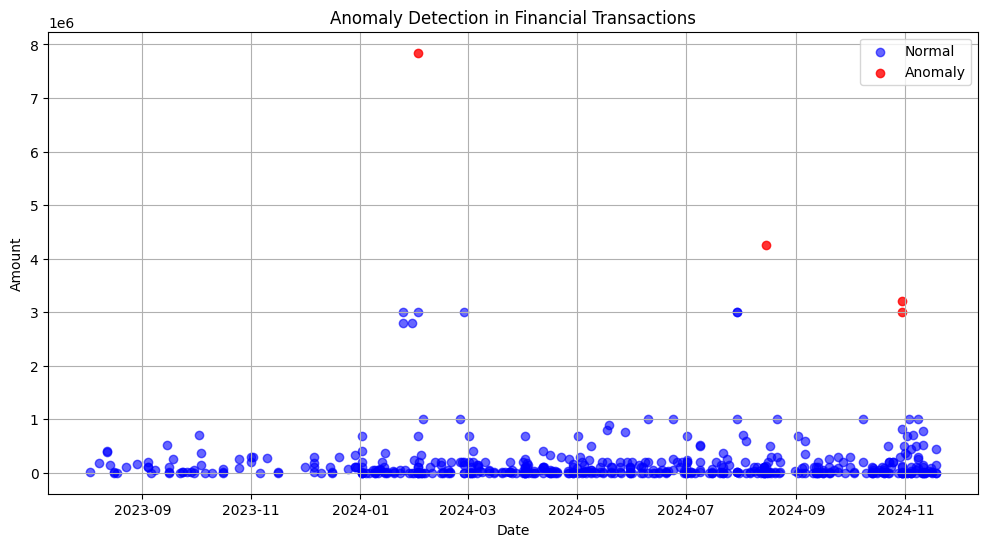

Processed Data with Anomaly Status:
     amount  day_of_week  month  day_of_month  year  day_of_year  \
0     20000            3      8             3  2023          215   
1    186450            1      8             8  2023          220   
2    384000            5      8            12  2023          224   
3    400000            5      8            12  2023          224   
4    150000            0      8            14  2023          226   
..      ...          ...    ...           ...   ...          ...   
494    5500            5     11            16  2024          321   
495  437000            0     11            18  2024          323   
496    2500            0     11            18  2024          323   
497  150000            0     11            18  2024          323   
498    2500            0     11            18  2024          323   

     reconstruction_error  is_anomaly       date  
0                0.002675       False 2023-08-03  
1                0.000832       False 2023-08

In [63]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses

# Function to preprocess the data
def preprocess_data(data):
    """
    Preprocesses the input data by extracting date-based features and normalizing values using MinMaxScaler.

    Parameters:
        data (pd.DataFrame): Input dataframe with 'date' and 'amount' columns.

    Returns:
        np.ndarray: Scaled feature matrix.
        pd.DataFrame: Original data with extracted features.
        MinMaxScaler: Fitted scaler for potential reuse.
    """
    # Convert 'date' to datetime and extract features
    data['date'] = pd.to_datetime(data['date'])
    data['day_of_week'] = data['date'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
    data['month'] = data['date'].dt.month           # Month of the year (1=January, 12=December)
    data['day_of_month'] = data['date'].dt.day      # Day of the month (1-31)
    data['year'] = data['date'].dt.year             # Year
    data['day_of_year'] = data['date'].dt.dayofyear # Day of the year (1-365 or 366)

    # Select relevant features
    features = ['amount', 'day_of_week', 'month', 'day_of_month', 'year', 'day_of_year']
    data = data[features]

    # Normalize the data using MinMaxScaler
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    return data_scaled, data, scaler


# Function to build the autoencoder model
def build_autoencoder(input_dim):
    """
    Builds and compiles an autoencoder model.

    Parameters:
        input_dim (int): Number of input features.

    Returns:
        tf.keras.Model: Compiled autoencoder model.
    """
    autoencoder = models.Sequential([
        layers.Input(shape=(input_dim,)),       # Input layer
        layers.Dense(32, activation='relu'),    # Encoder
        layers.Dense(16, activation='relu'),    # Encoder
        layers.Dense(8, activation='relu'),     # Bottleneck
        layers.Dense(16, activation='relu'),    # Decoder
        layers.Dense(32, activation='relu'),    # Decoder
        layers.Dense(input_dim, activation='sigmoid')  # Output layer
    ])
    autoencoder.compile(optimizer=optimizers.Adam(), loss=losses.MeanSquaredError())
    return autoencoder

# Function to detect anomalies
def detect_anomalies(autoencoder, data_scaled, original_data, scaler, percentile=99):
    """
    Detects anomalies using the trained autoencoder.

    Parameters:
        autoencoder (tf.keras.Model): Trained autoencoder model.
        data_scaled (np.ndarray): Normalized input data.
        original_data (pd.DataFrame): Original data with features.
        scaler (MinMaxScaler): Scaler used for normalization.
        percentile (float): Percentile threshold for anomaly detection.

    Returns:
        pd.DataFrame: Data with anomaly status and reconstruction errors.
        pd.DataFrame: Detected anomalies.
    """
    # Reconstruct the input data
    reconstructed = autoencoder.predict(data_scaled)
    mse = np.mean(np.power(data_scaled - reconstructed, 2), axis=1)  # Reconstruction error

    # Set anomaly threshold
    threshold = np.percentile(mse, percentile)

    # Flag anomalies
    original_data['reconstruction_error'] = mse
    original_data['is_anomaly'] = mse > threshold

    # Filter anomalies
    anomalies = original_data[original_data['is_anomaly']]

    return original_data, anomalies

# Function to plot the data
def plot_results(processed_data, anomalies):
    """
    Plots the data, highlighting anomalies in red and normal data in blue, with 'date' on the x-axis and 'amount' on the y-axis.

    Parameters:
        processed_data (pd.DataFrame): Dataframe with anomaly status.
        anomalies (pd.DataFrame): Detected anomalies.
    """
    # Reconstruct a synthetic 'date' from year and day_of_year
    processed_data['date'] = pd.to_datetime(processed_data['year'] * 1000 + processed_data['day_of_year'], format='%Y%j')
    anomalies['date'] = pd.to_datetime(anomalies['year'] * 1000 + anomalies['day_of_year'], format='%Y%j')

    plt.figure(figsize=(12, 6))

    # Plot normal data
    normal_data = processed_data[~processed_data['is_anomaly']]
    plt.scatter(normal_data['date'], normal_data['amount'], color='blue', label='Normal', alpha=0.6)

    # Plot anomalies
    plt.scatter(anomalies['date'], anomalies['amount'], color='red', label='Anomaly', alpha=0.8)

    # Add labels and legend
    plt.title('Anomaly Detection in Financial Transactions')
    plt.xlabel('Date')
    plt.ylabel('Amount')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main function to run the pipeline
def main_pipeline(data, epochs=50, batch_size=16, percentile=99):
    """
    Main pipeline for anomaly detection using autoencoder.

    Parameters:
        data (pd.DataFrame): Input dataframe with 'date' and 'amount' columns.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        percentile (float): Percentile threshold for anomaly detection.

    Returns:
        tf.keras.Model: Trained autoencoder model.
        pd.DataFrame: Processed data with anomaly status.
        pd.DataFrame: Detected anomalies.
        MinMaxScaler: Scaler used for data normalization.
        float: Threshold for anomaly detection based on reconstruction error.
    """
    # Step 1: Preprocess the data
    data_scaled, processed_data, scaler = preprocess_data(data)

    # Step 2: Build the autoencoder
    input_dim = data_scaled.shape[1]
    autoencoder = build_autoencoder(input_dim)

    # Step 3: Train the autoencoder
    history = autoencoder.fit(data_scaled, data_scaled, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1)

    # Step 4: Detect anomalies
    processed_data, anomalies = detect_anomalies(autoencoder, data_scaled, processed_data, scaler, percentile=percentile)

    # Step 5: Plot results
    plot_results(processed_data, anomalies)

    return autoencoder, processed_data, anomalies, scaler

def predict_pipeline(model, data, scaler, percentile):
    """
    Pipeline to preprocess data, predict anomalies, and plot results using a trained model.

    Parameters:
        model (tf.keras.Model): Trained autoencoder model.
        data (pd.DataFrame): New data with the same structure as training data.
        scaler (MinMaxScaler): Scaler used to preprocess the training data.
        percentile (float): Percentile for anomaly detection based on reconstruction error.

    Returns:
        pd.DataFrame: New data with anomaly status and reconstruction errors.
        pd.DataFrame: Detected anomalies.
    """
    # Step 1: Preprocess new data
    # Extract date-based features if not already extracted
    if 'day_of_week' not in data.columns:
        data['date'] = pd.to_datetime(data['date'])
        data['day_of_week'] = data['date'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
        data['month'] = data['date'].dt.month           # Month of the year (1=January, 12=December)
        data['day_of_month'] = data['date'].dt.day      # Day of the month (1-31)
        data['year'] = data['date'].dt.year             # Year
        data['day_of_year'] = data['date'].dt.dayofyear # Day of the year (1-365 or 366)

    # Select relevant features
    features = ['amount', 'day_of_week', 'month', 'day_of_month', 'year', 'day_of_year']
    data = data[features]

    # Normalize the data using the scaler from training
    data_scaled = scaler.transform(data)

    # Step 2: Use model to reconstruct data
    reconstructed = model.predict(data_scaled)
    mse = np.mean(np.power(data_scaled - reconstructed, 2), axis=1)

    # Step 3: Detect anomalies
    # Set anomaly threshold
    threshold = np.percentile(mse, percentile)

    # Flag the anomalies
    data['reconstruction_error'] = mse
    data['is_anomaly'] = mse > threshold

    # Step 4: Filter anomalies
    anomalies = data[data['is_anomaly']]

    # Step 5: Plot results
    plot_results(data, anomalies)

    return data, anomalies

def training_pipeline(model, data, scaler, epochs=50, batch_size=16):
    """
    Simplified pipeline to preprocess data and retrain an existing autoencoder model.

    Parameters:
        model (tf.keras.Model): Pre-trained autoencoder model.
        data (pd.DataFrame): Input data with 'date' and 'amount' columns.
        scaler (MinMaxScaler): Scaler used to preprocess the data during initial training.
        epochs (int): Number of epochs for retraining.
        batch_size (int): Batch size for training.

    Returns:
        tf.keras.Model: Retrained autoencoder model.
    """
    # Step 1: Preprocess the data using the existing scaler
    if 'day_of_week' not in data.columns:
        data['date'] = pd.to_datetime(data['date'])
        data['day_of_week'] = data['date'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
        data['month'] = data['date'].dt.month           # Month of the year (1=January, 12=December)
        data['day_of_month'] = data['date'].dt.day      # Day of the month (1-31)
        data['year'] = data['date'].dt.year             # Year
        data['day_of_year'] = data['date'].dt.dayofyear # Day of the year (1-365 or 366)
        data = data[['amount', 'day_of_week', 'month', 'day_of_month', 'year', 'day_of_year']]

    data_scaled = scaler.transform(data)

    # Step 2: Retrain the autoencoder
    model.fit(data_scaled, data_scaled, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1)

    return model

# Example usage
if __name__ == "__main__":
    # Example dataset
    data = pd.read_json('pengeluaran.json')

    # Run the pipeline
    autoencoder, processed_data, anomalies, scaler = main_pipeline(data, epochs=50, batch_size=4, percentile=99)

    # Display results
    print("Processed Data with Anomaly Status:")
    print(processed_data)

    print("\nDetected Anomalies:")
    print(anomalies)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


<ipython-input-63-da03c18467dd>:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['date'] = pd.to_datetime(anomalies['year'] * 1000 + anomalies['day_of_year'], format='%Y%j')


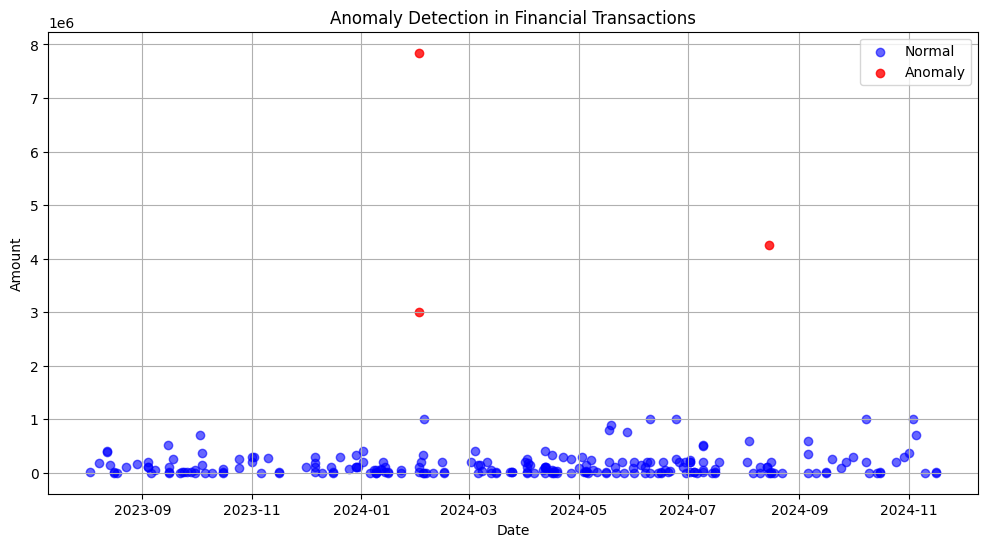

(      amount  day_of_week  month  day_of_month  year  day_of_year  \
 0     200000            0      9             4  2023          247   
 1     100000            0      9             4  2023          247   
 2     100000            0      9             4  2023          247   
 3        500            2      9             6  2023          249   
 4      50000            4      9             8  2023          251   
 ..       ...          ...    ...           ...   ...          ...   
 224  1000000            6     11             3  2024          308   
 225   700000            1     11             5  2024          310   
 226     3000            6     11            10  2024          315   
 227     2500            5     11            16  2024          321   
 228     5500            5     11            16  2024          321   
 
      reconstruction_error  is_anomaly       date  
 0                0.000458       False 2023-09-04  
 1                0.000463       False 2023-09-04  
 2

In [64]:
bri_data = pd.read_json('bri_pengeluaran.json')

predict_pipeline(model=autoencoder, data=bri_data, scaler=scaler, percentile=99)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


<ipython-input-63-da03c18467dd>:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['date'] = pd.to_datetime(anomalies['year'] * 1000 + anomalies['day_of_year'], format='%Y%j')


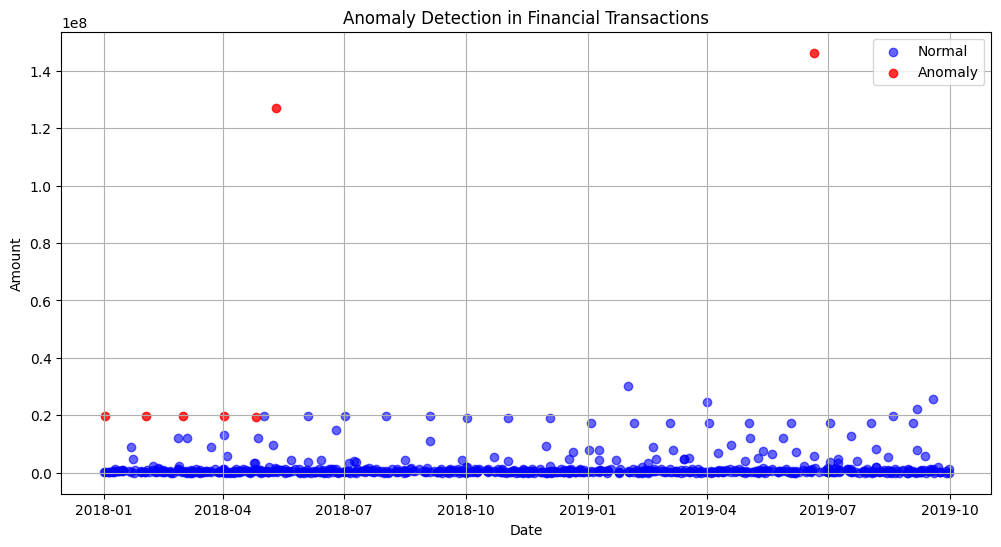

(         amount  day_of_week  month  day_of_month  year  day_of_year  \
 0      176649.0            0      1             1  2018            1   
 1    19834296.0            1      1             2  2018            2   
 2      385098.0            1      1             2  2018            2   
 3      186984.0            3      1             4  2018            4   
 4      411015.0            4      1             5  2018            5   
 ..          ...          ...    ...           ...   ...          ...   
 683    391617.0            0      9            23  2019          266   
 684    532014.0            5      9            28  2019          271   
 685     67893.0            5      9            28  2019          271   
 686     27825.0            0      9            30  2019          273   
 687   1192500.0            0      9            30  2019          273   
 
      reconstruction_error  is_anomaly       date  
 0                4.384111       False 2018-01-01  
 1                

In [65]:
pf_data = pd.read_json('pf_pengeluaran.json')

predict_pipeline(model=autoencoder, data=pf_data, scaler=scaler, percentile=99)

In [67]:
import pickle

# Simpan model dalam format HDF5
# Menyimpan model ke file
autoencoder.save('autoencoder_model.h5')  # Format HDF5
# atau menggunakan format SavedModel
autoencoder.export('autoencoder_model/')


# Simpan scaler menggunakan pickle
scaler_pickle_path = "scaler.pkl"
with open(scaler_pickle_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"Scaler saved to: {scaler_pickle_path}")


Saved artifact at 'autoencoder_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 6), dtype=tf.float32, name='keras_tensor_273')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  138533067851552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138533067851904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138533067864752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138533067854544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138533030983312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138532734930432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138532734934656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138533067851024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138533494247088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138533065170912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138533065164928: T